In [1]:
import sys
sys.path.append('/home/wangs/rs/lib')
import ff
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("whitegrid")
sns.set_palette("pastel")
from multiprocessing import Pool
from tqdm import tqdm
import statsmodels.api as sm
from datetime import datetime
import mplfinance as mpf
from functools import partial

In [2]:
up = ff.read('up').loc[:,'20200102':'20240305']

In [3]:
up_filter = up  *  up.shift(1,axis = 1).replace({np.nan:1,1:np.nan}) * up.shift(-1,axis = 1).replace({np.nan:1,1:np.nan})
filtered_index = up_filter.index.str.startswith('300') | up_filter.index.str.startswith('688') | up_filter.index.str.endswith('BJ')
up_filter.loc[filtered_index,:] = np.nan

In [4]:
open = (ff.read('open')*ff.read('post')).loc[:,'20200102':'20240305']
close = (ff.read('close')*ff.read('post')).loc[:,'20200102':'20240305']
high = (ff.read('high')*ff.read('post')).loc[:,'20200102':'20240305']
low = (ff.read('low')*ff.read('post')).loc[:,'20200102':'20240305']

In [5]:
def daily_K_line(event,n,open,close,high,low):
    # 日均事件K线
    T0open=event*open  # 以T0open作为基准
    pre_close = event * close.shift(axis = 1)
    data=pd.DataFrame(columns=['T'+str(j) for j in range(n)])
    for j in range(n):
        _open=(event*open.shift(-j,axis=1))/pre_close
        _close=(event*close.shift(-j,axis=1))/pre_close
        _low=(event*low.shift(-j,axis=1))/pre_close
        _high=(event*high.shift(-j,axis=1))/pre_close
        lst=[_open.mean().mean(),_close.mean().mean(),_low.mean().mean(),_high.mean().mean()]
        data['T'+str(j)]=lst
    data.index=['open','close','low','high']
    data=data.T
    data.index=pd.to_datetime(['20200101','20200102','20200103','20200104','20200105'])
    mpf.plot(data,type='candle',style='default')
    return data

连续两日涨停，收盘价相比最低价涨幅最小的分组


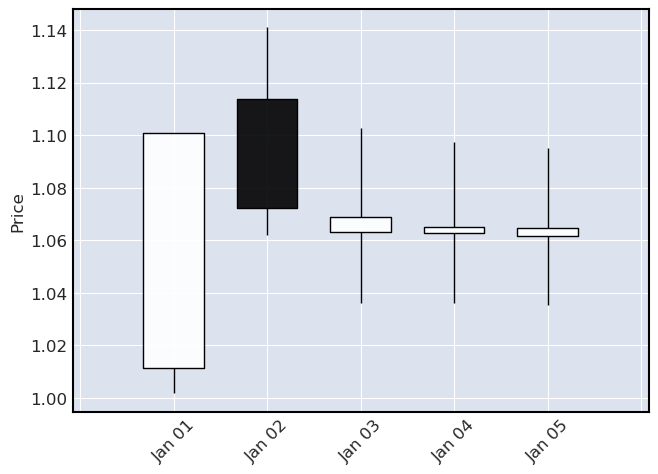

,open,close,low,high
2020-01-01,1.011571,1.100763,1.001765,1.100763
2020-01-02,1.113845,1.072333,1.062137,1.140997
2020-01-03,1.063082,1.068953,1.036139,1.102700
2020-01-04,1.062623,1.065043,1.035983,1.097329
2020-01-05,1.061638,1.064843,1.035287,1.095147


In [6]:
low_judge = ((close/low)* up_filter.shift(1,axis = 1) < ((close/low) * up_filter.shift(1,axis = 1)).quantile(1/3)).replace({False:np.nan,True:1}) * ff.filter0
low_judge = low_judge.shift(-1,axis = 1)
print('连续两日涨停，收盘价相比最低价涨幅最小的分组')
daily_K_line(low_judge,5,open,close,high,low)

连续两日涨停，收盘价相比最低价涨幅最大的分组


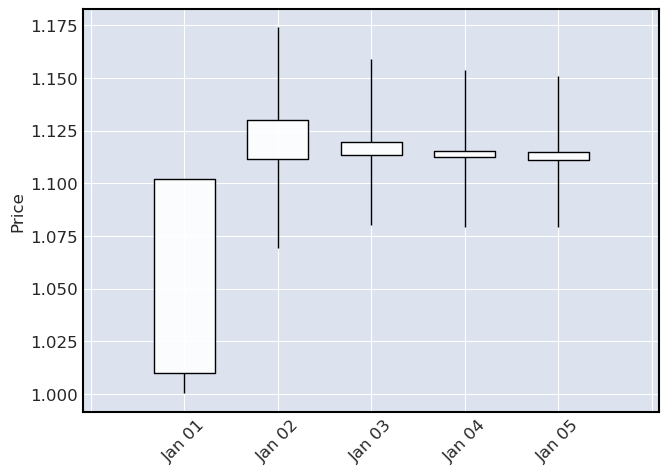

,open,close,low,high
2020-01-01,1.010042,1.101848,1.000223,1.101848
2020-01-02,1.111392,1.130199,1.069461,1.173997
2020-01-03,1.113299,1.119701,1.079997,1.159124
2020-01-04,1.112257,1.115491,1.079394,1.153954
2020-01-05,1.111188,1.115059,1.079322,1.150873


In [7]:
print('连续两日涨停，收盘价相比最低价涨幅最大的分组')
low_judge = ((close/low)* up_filter.shift(1,axis = 1) > ((close/low) * up_filter.shift(1,axis = 1)).quantile(2/3)).replace({False:np.nan,True:1}) * ff.filter0
low_judge = low_judge.shift(-1,axis = 1)
daily_K_line(low_judge,5,open,close,high,low)

连续两日涨停，收盘价相比最低价涨幅适中的分组


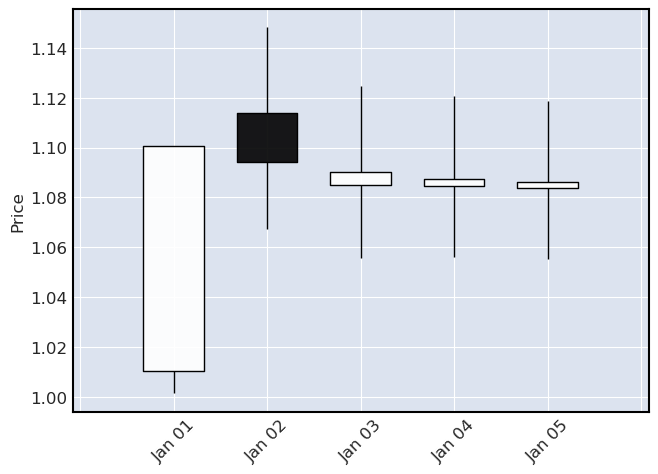

,open,close,low,high
2020-01-01,1.010414,1.100770,1.001335,1.100770
2020-01-02,1.113902,1.094303,1.067415,1.148196
2020-01-03,1.084995,1.090140,1.055740,1.124735
2020-01-04,1.084389,1.087282,1.056001,1.120767
2020-01-05,1.083622,1.086352,1.055158,1.118831


In [8]:
print('连续两日涨停，收盘价相比最低价涨幅适中的分组')
mid_judge = ((close/low)* up_filter.shift(1,axis = 1) <= ((close/low) * up_filter.shift(1,axis = 1)).quantile(2/3)) * ((close/low)* up_filter.shift(1,axis = 1) >= ((close/low) * up_filter.shift(1,axis = 1)).quantile(1/3)) 
mid_judge = (mid_judge.replace({False:np.nan,True:1}) * ff.filter0).shift(-1,axis = 1)
daily_K_line(mid_judge,5,open,close,high,low)

连续涨停（2日）

In [9]:
up = ff.read('up').loc[ff.read('up_limit').index,'20200102':'20240305']
condition_1 = up  *  up.shift(-1,axis = 1) *  up.shift(1,axis = 1).replace({np.nan:1,1:np.nan}) #连续两日涨停

In [10]:
condition_2 = (ff.read('open').loc[ff.read('up_limit').index,'20200102':'20240305'] != ff.read('up_limit').loc[:,'20200102':'20240305']).shift(-1, axis = 1)#T1开盘非涨停

In [11]:
condition_3 = (ff.read('close').loc[ff.read('up_limit').index,'20200102':'20240305'] != ff.read('up_limit').loc[:,'20200102':'20240305']).replace({True:1,False:0})
condition_3 = (condition_3.rolling(window = 5,axis = 1,closed = 'left').sum() == 5) #前五天的条件

In [12]:
condition_4 = (ff.read('open').loc[ff.read('up_limit').index,'20200102':'20240305'] != ff.read('up_limit').loc[:,'20200102':'20240305']).shift(-3, axis = 1)# T3开盘非涨停

In [13]:
condition_5 =  (ff.read('close').loc[ff.read('up_limit').index,'20200102':'20240305'] != ff.read('up_limit').loc[:,'20200102':'20240305']).replace({True:1,False:0}).shift(-2, axis = 1) # T2尾盘非涨停

In [14]:
filter_2 = condition_1 * condition_2 * condition_3 #* condition_4 * condition_5
filtered_index = filter_2.index.str.startswith('300') | filter_2.index.str.startswith('688') | filter_2.index.str.endswith('BJ')
filter_2.loc[filtered_index,:] = np.nan

In [15]:
open = (ff.read('open')*ff.read('post')).loc[ff.read('up_limit').index,'20200102':'20240305']
close = (ff.read('close')*ff.read('post')).loc[ff.read('up_limit').index,'20200102':'20240305']
high = (ff.read('high')*ff.read('post')).loc[ff.read('up_limit').index,'20200102':'20240305']
low = (ff.read('low')*ff.read('post')).loc[ff.read('up_limit').index,'20200102':'20240305']

连续涨停2日


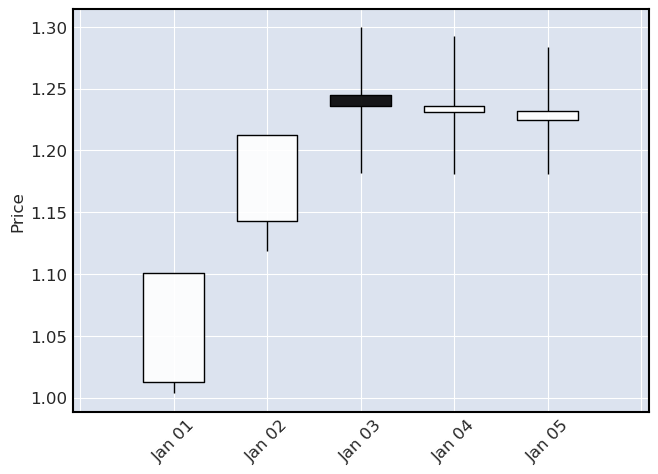

,open,close,low,high
2020-01-01,1.012972,1.101129,1.003455,1.101129
2020-01-02,1.143084,1.212522,1.118439,1.212522
2020-01-03,1.244853,1.236247,1.181545,1.299396
2020-01-04,1.231426,1.235635,1.180689,1.292306
2020-01-05,1.224584,1.231757,1.180901,1.283932


In [16]:
print('连续涨停2日')
daily_K_line(filter_2,5,open,close,high,low)

In [17]:
print('连续涨停2日')
print('日均发生次数:',filter_2.sum().mean()) 
print('日均发生中位数:',filter_2.sum().median())
print('日均发生概率',(filter_2.sum()>0).sum()/filter_2.shape[1])

连续涨停2日
日均发生次数: 3.4623762376237623
日均发生中位数: 3.0
日均发生概率 0.903960396039604


连续涨停2日, T1T1开盘非涨停,T2尾盘非涨停，T3开盘非涨停


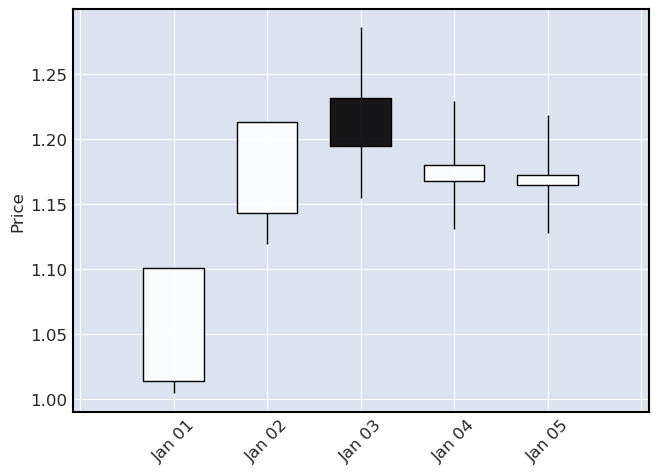

,open,close,low,high
2020-01-01,1.014206,1.101381,1.004704,1.101381
2020-01-02,1.143051,1.213102,1.119140,1.213102
2020-01-03,1.231314,1.194619,1.154699,1.285896
2020-01-04,1.167788,1.179878,1.130937,1.229155
2020-01-05,1.164645,1.172221,1.128251,1.218309


In [20]:
filter_2 = condition_1 * condition_2 * condition_3 * condition_4 * condition_5
filtered_index = filter_2.index.str.startswith('300') | filter_2.index.str.startswith('688') | filter_2.index.str.endswith('BJ')
filter_2.loc[filtered_index,:] = np.nan
print('连续涨停2日, T1T1开盘非涨停,T2尾盘非涨停，T3开盘非涨停')
daily_K_line(filter_2,5,open,close,high,low)

In [19]:
print('连续涨停2日,且T2尾盘非涨停，T3开盘非涨停')
print('日均发生次数:',filter_2.sum().mean()) 
print('日均发生中位数:',filter_2.sum().median())
print('日均发生概率',(filter_2.sum()>0).sum()/filter_2.shape[1])

连续涨停2日,且T2尾盘非涨停，T3开盘非涨停
日均发生次数: 2.4722772277227723
日均发生中位数: 2.0
日均发生概率 0.8227722772277227


In [20]:
condition_1 = up  *  up.shift(-1,axis = 1) *  up.shift(1,axis = 1).replace({np.nan:1,1:np.nan}) *  up.shift(-2,axis = 1)#连续三日涨停
condition_4 = (ff.read('open').loc[ff.read('up_limit').index,'20200102':'20240305'] != ff.read('up_limit').loc[:,'20200102':'20240305']).shift(-2, axis = 1)# T2开盘非涨停

In [27]:
def daily_K_line(event,n,open,close,high,low):
    # 日均事件K线
    T0open=event*open  # 以T0open作为基准
    pre_close = event * close.shift(axis = 1)
    data=pd.DataFrame(columns=['T'+str(j) for j in range(n)])
    for j in range(n):
        _open=(event*open.shift(-j,axis=1))/pre_close
        _close=(event*close.shift(-j,axis=1))/pre_close
        _low=(event*low.shift(-j,axis=1))/pre_close
        _high=(event*high.shift(-j,axis=1))/pre_close
        lst=[_open.mean().mean(),_close.mean().mean(),_low.mean().mean(),_high.mean().mean()]
        data['T'+str(j)]=lst
    data.index=['open','close','low','high']
    data=data.T
    data.index=pd.to_datetime(['20200101','20200102','20200103','20200104','20200105','20200106','20200107'])
    print(data)
    mpf.plot(data,type='candle',style='default')
    return data

连续涨停3日 T2开盘非涨停 T-5日到T-1日，没有出现过收盘涨停
                open     close       low      high
2020-01-01  1.014183  1.100748  1.005478  1.100748
2020-01-02  1.159705  1.211672  1.132864  1.211672
2020-01-03  1.259320  1.333776  1.221197  1.333776
2020-01-04  1.367971  1.356569  1.286893  1.433641
2020-01-05  1.347763  1.356723  1.288692  1.422828
2020-01-06  1.340375  1.347673  1.290698  1.410077
2020-01-07  1.334935  1.342850  1.284488  1.399770


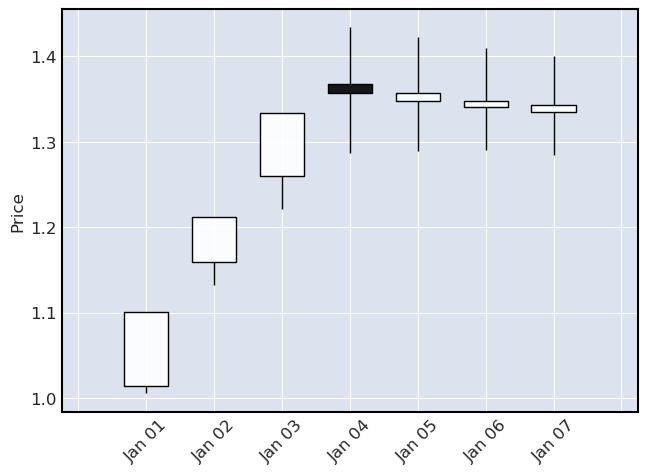

,open,close,low,high
2020-01-01,1.014183,1.100748,1.005478,1.100748
2020-01-02,1.159705,1.211672,1.132864,1.211672
2020-01-03,1.259320,1.333776,1.221197,1.333776
2020-01-04,1.367971,1.356569,1.286893,1.433641
2020-01-05,1.347763,1.356723,1.288692,1.422828
2020-01-06,1.340375,1.347673,1.290698,1.410077
2020-01-07,1.334935,1.342850,1.284488,1.399770


In [22]:
filter_2 = condition_1 * condition_3 * condition_4
filtered_index = filter_2.index.str.startswith('300') | filter_2.index.str.startswith('688') | filter_2.index.str.endswith('BJ')
filter_2.loc[filtered_index,:] = np.nan
print('连续涨停3日 T2开盘非涨停 T-5日到T-1日，没有出现过收盘涨停')
daily_K_line(filter_2,7,open,close,high,low)

In [23]:
print('连续涨停3日')
print('日均发生次数:',filter_2.sum().mean()) 
print('日均发生中位数:',filter_2.sum().median())
print('日均发生概率',(filter_2.sum()>0).sum()/filter_2.shape[1])

连续涨停3日
日均发生次数: 0.9504950495049505
日均发生中位数: 1.0
日均发生概率 0.592079207920792


首板炸板

In [38]:
def daily_K_line(event,n,open,close,high,low):
    # 日均事件K线
    T0open=event*open  # 以T0open作为基准
    pre_close = event * close.shift(axis = 1)
    data=pd.DataFrame(columns=['T'+str(j) for j in range(n)])
    for j in range(n):
        _open=(event*open.shift(-j,axis=1))/pre_close
        _close=(event*close.shift(-j,axis=1))/pre_close
        _low=(event*low.shift(-j,axis=1))/pre_close
        _high=(event*high.shift(-j,axis=1))/pre_close
        lst=[_open.mean().mean(),_close.mean().mean(),_low.mean().mean(),_high.mean().mean()]
        data['T'+str(j)]=lst
    data.index=['open','close','low','high']
    data=data.T
    print(data)
    data.index=pd.to_datetime(['20200101','20200102','20200103','20200104','20200105'])
    mpf.plot(data,type='candle',style='default')
    return data

In [46]:
condition_1_1 = (ff.read('high').loc[ff.read('up_limit').index,'20200102':'20240305'] >= ff.read('up_limit').loc[:,'20200102':'20240305']) # T0日最高价涨停
condition_1_2 = (ff.read('close').loc[ff.read('up_limit').index,'20200102':'20240305'] < ff.read('up_limit').loc[:,'20200102':'20240305']) # T0日尾板不涨停
condition_1_3 = (ff.read('open').loc[ff.read('up_limit').index,'20200102':'20240305'] < ff.read('up_limit').loc[:,'20200102':'20240305']).shift(-1,axis = 1) # T1日开盘不涨停
condition_1 = (condition_1_1 * condition_1_2).replace({True:1,False:0})

In [47]:
condition_3 = (ff.read('close').loc[ff.read('up_limit').index,'20200102':'20240305'] < ff.read('up_limit').loc[:,'20200102':'20240305']).replace({True:1,False:0})
condition_3 = (condition_3.rolling(window = 5,axis = 1,closed = 'left').sum() == 5) #前五天的条件

In [48]:
condition_4_open_high = (ff.read('open').loc[ff.read('up_limit').index,'20200102':'20240305'] / ff.read('pre_close').loc[ff.read('up_limit').index,'20200102':'20240305']-1 >0.018).shift(-1,axis = 1).replace({True:1,False:0})  # T2开盘的分组

首板炸板 high T0日最高价涨停 T0日尾板不涨停 T1收盘价大于1.8%
        open     close       low      high
T0  1.008798  1.064364  0.996266  1.100969
T1  1.100847  1.102774  1.059820  1.140364
T2  1.104500  1.106531  1.067596  1.144080
T3  1.107907  1.109074  1.074542  1.148832
T4  1.108064  1.111333  1.075466  1.146651


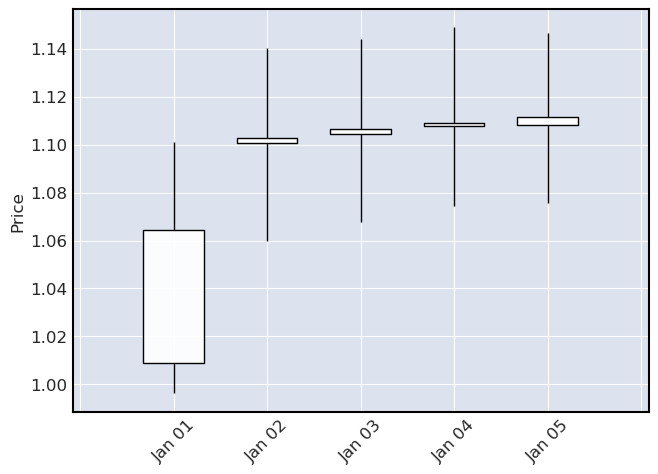

首板炸板 high
日均发生次数: 0.8722772277227723
日均发生中位数: 0.0
日均发生概率 0.46633663366336636


In [49]:
filter_2 = condition_1 * condition_3 * condition_4_open_high  * ff.filter0.loc[filter_2.index,filter_2.columns]
filtered_index = filter_2.index.str.startswith('300') | filter_2.index.str.startswith('688') | filter_2.index.str.endswith('BJ')
filter_2.loc[filtered_index,:] = np.nan
print('首板炸板 high T0日最高价涨停 T0日尾板不涨停 T1收盘价大于1.8%')
daily_K_line(filter_2,5,open,close,high,low)
print('首板炸板 high')
print('日均发生次数:',filter_2.sum().mean()) 
print('日均发生中位数:',filter_2.sum().median())
print('日均发生概率',(filter_2.sum()>0).sum()/filter_2.shape[1])

首板炸板 low T0日最高价涨停 T0日尾板不涨停 T1收盘价小于-1.8%
        open     close       low      high
T0  1.012201  1.063558  0.996331  1.102131
T1  1.030784  1.038787  1.005793  1.071462
T2  1.032159  1.033706  1.006459  1.065021
T3  1.030411  1.032896  1.006355  1.061863
T4  1.030679  1.031317  1.006326  1.058920


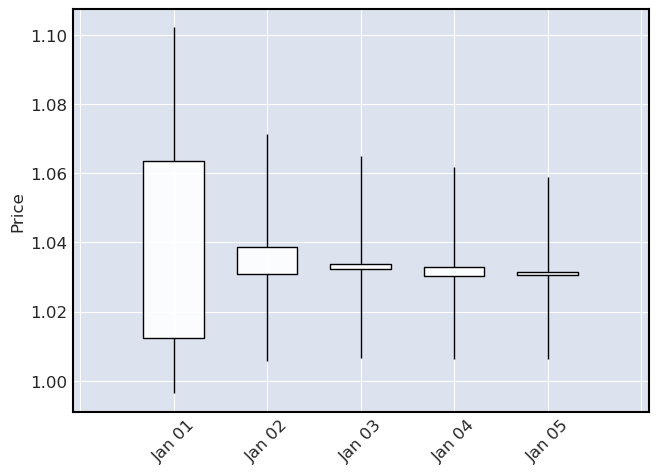

首板炸板 low
日均发生次数: 4.44950495049505
日均发生中位数: 4.0
日均发生概率 0.9277227722772278


In [56]:
condition_4_open_low = (ff.read('open').loc[ff.read('up_limit').index,'20200102':'20240305'] / ff.read('pre_close').loc[ff.read('up_limit').index,'20200102':'20240305']-1 <-0.018).shift(-1,axis = 1).replace({True:1,False:0})
filter_2 = condition_1 * condition_3 * condition_4_open_low  * ff.filter0.loc[filter_2.index,filter_2.columns]
filtered_index = filter_2.index.str.startswith('300') | filter_2.index.str.startswith('688') | filter_2.index.str.endswith('BJ')
filter_2.loc[filtered_index,:] = np.nan
print('首板炸板 low T0日最高价涨停 T0日尾板不涨停 T1收盘价小于-1.8%')
daily_K_line(filter_2,5,open,close,high,low)
print('首板炸板 low')
print('日均发生次数:',filter_2.sum().mean()) 
print('日均发生中位数:',filter_2.sum().median())
print('日均发生概率',(filter_2.sum()>0).sum()/filter_2.shape[1])

首板炸板 mid T0日最高价涨停 T0日尾板不涨停 T1收盘价在-1.8%与1.8%之间
        open     close       low      high
T0  1.008592  1.062299  0.997000  1.100384
T1  1.058148  1.062484  1.029145  1.095036
T2  1.059291  1.060380  1.032976  1.090942
T3  1.058992  1.060866  1.033209  1.089603
T4  1.058941  1.060109  1.033344  1.088770


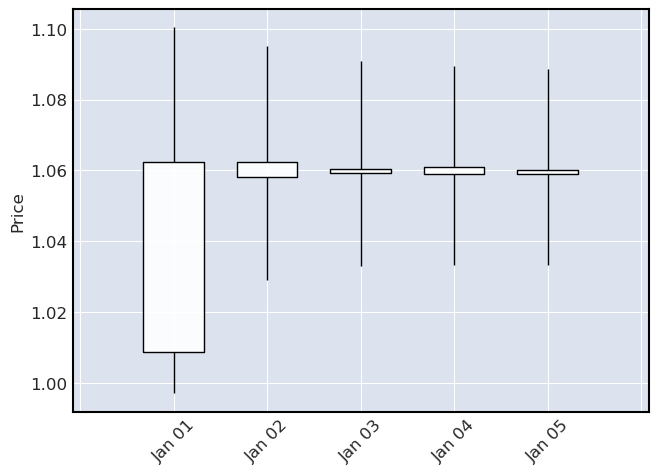

首板炸板 mid
日均发生次数: 9.016831683168316
日均发生中位数: 8.0
日均发生概率 0.9841584158415841


In [51]:
condition_4_open_mid = (ff.read('open').loc[ff.read('up_limit').index,'20200102':'20240305'] / ff.read('pre_close').loc[ff.read('up_limit').index,'20200102':'20240305']-1 >=-0.018).shift(-1,axis = 1).replace({True:1,False:0}) * (ff.read('open').loc[ff.read('up_limit').index,'20200102':'20240305'] / ff.read('pre_close').loc[ff.read('up_limit').index,'20200102':'20240305']-1 <=0.018).shift(-1,axis = 1).replace({True:1,False:0})
filter_2 = condition_1 * condition_3 * condition_4_open_mid  * ff.filter0.loc[filter_2.index,filter_2.columns]
filtered_index = filter_2.index.str.startswith('300') | filter_2.index.str.startswith('688') | filter_2.index.str.endswith('BJ')
filter_2.loc[filtered_index,:] = np.nan
print('首板炸板 mid T0日最高价涨停 T0日尾板不涨停 T1收盘价在-1.8%与1.8%之间')
daily_K_line(filter_2,5,open,close,high,low)
print('首板炸板 mid')
print('日均发生次数:',filter_2.sum().mean()) 
print('日均发生中位数:',filter_2.sum().median())
print('日均发生概率',(filter_2.sum()>0).sum()/filter_2.shape[1])

In [31]:
stock_list = filter_2.T.stack()[filter_2.T.stack() !=0]
stock_list = list(stock_list.index)

In [32]:
grouped = {}
for key, value in stock_list:
    if key not in grouped:
        grouped[key] = []
    grouped[key].append(value)

In [33]:
ret_all = []
for day in tqdm(grouped.keys()):
    stock = grouped[day]
    ret_daily = []
    for i in stock:
        data_daily = ff.read_min(i).copy()
        data_daily.index = pd.to_datetime(ff.read_min(i).index).strftime('%Y%m%d')
        ret_daily.append((data_daily.loc[day,'close']/data_daily.loc[day,'open'][0] - 1).values)
    ret_all.append(np.mean(ret_daily,axis = 0))

  0%|▍                                                                                                                                | 3/994 [00:21<1:56:04,  7.03s/it]


KeyboardInterrupt: 

In [ ]:
plt.plot(np.mean(ret_all,axis = 0))

In [ ]:
plt.plot(ret_all[1])

In [34]:
(ff.read('high').loc[:,'20200102':'20240305']-ff.read('close').loc[ff.read('up_limit').index,'20200102':'20240305']) * condition_1 * condition_3 * condition_4_open_mid  * ff.filter0.loc[filter_2.index,filter_2.columns]

,20200102,20200103,20200106,20200107,20200108,20200109,20200110,20200113,20200114,20200115,...,20240221,20240222,20240223,20240226,20240227,20240228,20240229,20240301,20240304,20240305
000001.SZ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
000002.SZ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
000004.SZ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
000005.SZ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
000006.SZ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
873703.BJ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
873706.BJ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
873726.BJ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
873806.BJ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [35]:
data_filter = (condition_1 * condition_3 * condition_4_open_high  * ff.filter0.loc[filter_2.index,filter_2.columns]).replace({0.0:np.nan})
filtered_index = data_filter.index.str.startswith('300') | data_filter.index.str.startswith('688') | data_filter.index.str.endswith('BJ')
data_filter.loc[filtered_index,:] = np.nan

In [36]:
high_filter = ff.read('high').loc[:,'20200102':'20240305']
close_filter = ff.read('close').loc[ff.read('up_limit').index,'20200102':'20240305']

首板炸板 mid T0日最高价涨停 T0日尾板不涨停 T1日开盘不涨停 T1开盘高开
        open     close       low      high
T0  1.011660  1.061179  0.997258  1.101850
T1  1.095341  1.099702  1.051994  1.134225
T2  1.101180  1.102532  1.064875  1.141436
T3  1.105973  1.105529  1.069282  1.143887
T4  1.104835  1.105431  1.071450  1.142184


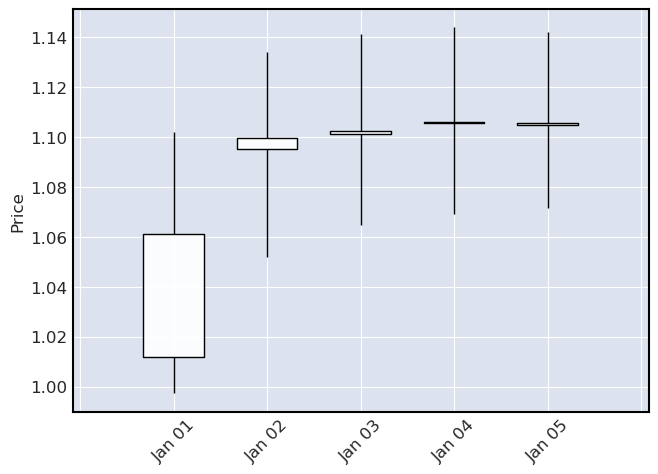

首板炸板 mid
日均发生次数: 0.22871287128712872
日均发生中位数: 0.0
日均发生概率 0.16930693069306932


In [37]:
condition_5 = ((high_filter-close_filter)  * data_filter > ((high_filter-close_filter)  * data_filter).quantile(2/3)).replace({True:1,False:0}) 
filter_2 = condition_1 * condition_3 * condition_4_open_high  * condition_5 * ff.filter0.loc[filter_2.index,filter_2.columns] 
filtered_index = filter_2.index.str.startswith('300') | filter_2.index.str.startswith('688') | filter_2.index.str.endswith('BJ')
filter_2.loc[filtered_index,:] = np.nan
print('首板炸板 mid T0日最高价涨停 T0日尾板不涨停 T1日开盘不涨停 T1开盘高开')
daily_K_line(filter_2,5,open,close,high,low)
print('首板炸板 mid')
print('日均发生次数:',filter_2.sum().mean()) 
print('日均发生中位数:',filter_2.sum().median())
print('日均发生概率',(filter_2.sum()>0).sum()/filter_2.shape[1])